In [1]:
from quantumnet.components import Network, Host, Controller
from quantumnet.components import ServerNode, ClientNode, RegularNode
from quantumnet.objects import Qubit, Logger
from quantumnet.components.simulation import ClassificadorQML

import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit

In [2]:
# # Inicializar a rede e o controlador
# rede = Network()
# controlador = Controller(rede)

# # Configura uma grade 4x4
# clients = [0,3]
# server = 10
# rede.set_topology_for_slices(graph_type='grade', dimensions=(4, 4), clients=clients, server=server)

# # Visualizar a topologia da rede
# rede.draw()

# # Executa a simulação de slices
# slice_paths_list = rede.run_slice_simulation(clients=clients, server=server)
# Logger.activate(Logger)

# # Inicializa slices para cada cliente
# protocols = ["AC_BQC","BFK_BQC"]  # Lista de protocolos
# controlador.initialize_slices(
#     network=rede,
#     clients=clients,
#     server=server,
#     protocols=protocols,
#     slice_paths_list=slice_paths_list
    
# )

# # Carregar o conjunto de dados do PennyLane
# pm = qml.data.load('other', name='plus-minus')
# dataset = pm[0]  # Acessando o primeiro elemento da lista

# X_train = dataset.img_train
# X_test = dataset.img_test
# Y_train = dataset.labels_train
# Y_test = dataset.labels_test

# # Visualizar uma imagem de cada classe
# x_vis = [
#     (X_train[Y_train == 0])[0],
#     (X_train[Y_train == 1])[0],
#     (X_train[Y_train == 2])[0],
#     (X_train[Y_train == 3])[0],
# ]
# y_vis = [0, 1, 2, 3]

# def visualize_data(x, y, pred=None):
#     n_img = len(x)
#     labels_list = ["−", "+", "꜔", "˧"]
#     fig, axes = plt.subplots(1, 4, figsize=(8, 2))
#     for i in range(n_img):
#         axes[i].imshow(x[i], cmap="gray")
#         if pred is None:
#             axes[i].set_title("Label: {}".format(labels_list[y[i]]))
#         else:
#             axes[i].set_title("Label: {}, Pred: {}".format(labels_list[y[i]], labels_list[pred[i]]))
#     plt.tight_layout(w_pad=2)

# visualize_data(x_vis, y_vis)

# # Hiperparâmetros 
# input_dim = 256
# num_classes = 4
# num_layers = 32
# num_qubits = 8
# num_reup = 3

# # Configuração do dispositivo
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# class QML_classifier(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, num_qubits, num_layers):
#         super().__init__()
#         torch.manual_seed(1337)
#         self.num_qubits = num_qubits
#         self.output_dim = output_dim
#         self.num_layers = num_layers
#         self.device = qml.device("lightning.qubit", wires=self.num_qubits)
#         self.weights_shape = qml.StronglyEntanglingLayers.shape(
#             n_layers=self.num_layers, n_wires=self.num_qubits
#         )

#         @qml.qnode(self.device)
#         def circuit(inputs, weights, bias):
#             inputs = torch.reshape(inputs, self.weights_shape)
#             qml.StronglyEntanglingLayers(
#                 weights=weights * inputs + bias, wires=range(self.num_qubits)
#             )
#             return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

#         param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
#         init_vals = {
#             "weights": 0.1 * torch.rand(self.weights_shape),
#             "bias": 0.1 * torch.rand(self.weights_shape),
#         }

#         self.qcircuit = qml.qnn.TorchLayer(
#             qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
#         )

#     def forward(self, x):
#         inputs_stack = torch.hstack([x] * num_reup)
#         return self.qcircuit(inputs_stack)

# # Hiperparâmetros de Treinamento 
# learning_rate = 0.1
# epochs = 4
# batch_size = 20

# # Preparar dados
# torch.manual_seed(1337)
# feats_train = torch.from_numpy(X_train[:200]).reshape(200, -1).to(device)
# feats_test = torch.from_numpy(X_test[:50]).reshape(50, -1).to(device)
# labels_train = torch.from_numpy(Y_train[:200]).to(device)
# labels_test = torch.from_numpy(Y_test[:50]).to(device)
# num_train = feats_train.shape[0]

# # Inicializar modelo, perda e otimizador
# qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
# loss = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
# num_batches = feats_train.shape[0] // batch_size

# # Funções auxiliares
# def accuracy(labels, predictions):
#     acc = sum(torch.argmax(p) == l for l, p in zip(labels, predictions)) / len(labels)
#     return acc

# def gen_batches(num_samples, num_batches):
#     assert num_samples % num_batches == 0
#     perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
#     return perm_ind

# # Função para exibir a acurácia
# def print_acc(epoch, max_ep=4):
#     predictions_train = [qml_model(f) for f in feats_train[:50]]
#     predictions_test = [qml_model(f) for f in feats_test]
#     cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
#     cost_approx_test = loss(torch.stack(predictions_test), labels_test)
#     acc_approx_train = accuracy(labels_train[:50], predictions_train)
#     acc_approx_test = accuracy(labels_test, predictions_test)
#     print(
#         f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:.7f} | Cost (val): {cost_approx_test:.7f} |"
#         f" Approx Acc train: {acc_approx_train:.7f} | Acc val: {acc_approx_test:.7f}"
#     )

# print(f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)...")


# # Treinamento
# for ep in range(epochs):
#     batch_ind = gen_batches(num_train, num_batches)
#     print_acc(epoch=ep)

#     for it in range(num_batches):
#         optimizer.zero_grad()
#         feats_train_batch = feats_train[batch_ind[it]]
#         labels_train_batch = labels_train[batch_ind[it]]

#         outputs = [qml_model(f) for f in feats_train_batch]
#         batch_loss = loss(torch.stack(outputs), labels_train_batch)
#         batch_loss.backward()
#         optimizer.step()

# print_acc(epochs)


Hosts inicializados
Canais inicializados
Pares EPRs adicionados
Topologia configurada com sucesso para slices!


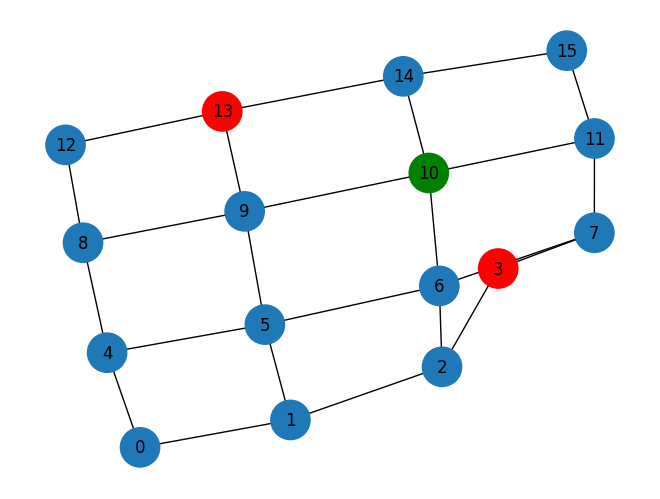

Final Slice Paths for 2 slices: [[13, 9, 10], [3, 2, 6, 10]]


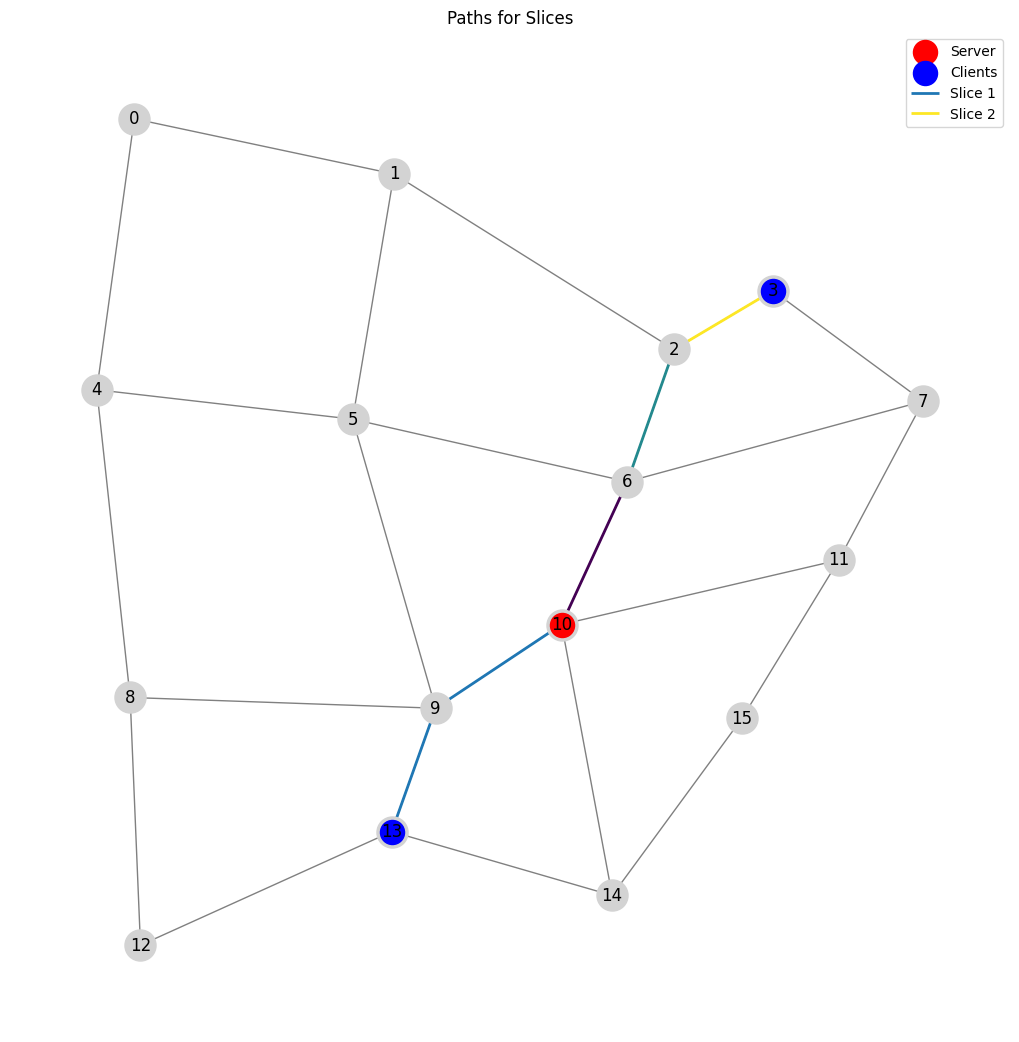

2025-02-10 17:58:12,181: Slice slice_1 configurado com cliente 13, servidor 10, protocolo AC_BQC e caminho [13, 9, 10].
2025-02-10 17:58:12,186: Slice slice_2 configurado com cliente 3, servidor 10, protocolo BFK_BQC e caminho [3, 2, 6, 10].


Using device: cpu


2025-02-10 17:58:12,782: Circuito gerado com 8 qubits e 32 portas. Instruções salvas.
2025-02-10 17:58:12,783: Instrução: {'operation': 'z', 'qubits': [3]}
2025-02-10 17:58:12,784: Instrução: {'operation': 't', 'qubits': [5]}
2025-02-10 17:58:12,786: Instrução: {'operation': 'swap', 'qubits': [4, 2]}
2025-02-10 17:58:12,787: Instrução: {'operation': 't', 'qubits': [3]}
2025-02-10 17:58:12,788: Instrução: {'operation': 'cx', 'qubits': [3, 6]}
2025-02-10 17:58:12,788: Instrução: {'operation': 'swap', 'qubits': [3, 7]}
2025-02-10 17:58:12,789: Instrução: {'operation': 's', 'qubits': [2]}
2025-02-10 17:58:12,789: Instrução: {'operation': 'cx', 'qubits': [1, 0]}
2025-02-10 17:58:12,790: Instrução: {'operation': 'swap', 'qubits': [3, 6]}
2025-02-10 17:58:12,790: Instrução: {'operation': 'x', 'qubits': [0]}
2025-02-10 17:58:12,792: Instrução: {'operation': 'cz', 'qubits': [6, 4]}
2025-02-10 17:58:12,795: Instrução: {'operation': 's', 'qubits': [6]}
2025-02-10 17:58:12,795: Instrução: {'operat

Executando as requisições na rede...
Pares EPRs adicionados
Hosts inicializados


2025-02-10 17:58:27,029: Fidelidade final: 0.9996 (F_qubit: 0.9120 * F_rota: 0.9996)
2025-02-10 17:58:27,031: Fidelidade do EPR 13->9: 0.999700029999
2025-02-10 17:58:27,034: Fidelidade do EPR 9->10: 0.999700029999
2025-02-10 17:58:27,043: Produto das fidelidades para rota [13, 9, 10]: 0.9994001499800015
2025-02-10 17:58:27,046: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:27,048: Fidelidade final: 0.9994 (F_qubit: 0.9740 * F_rota: 0.9994)
2025-02-10 17:58:27,048: Fidelidade do EPR 13->9: 0.9996000599960001
2025-02-10 17:58:27,049: Fidelidade do EPR 9->10: 0.9996000599960001
2025-02-10 17:58:27,050: Produto das fidelidades para rota [13, 9, 10]: 0.999200279944007
2025-02-10 17:58:27,050: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:27,051: Fidelidade final: 0.9992 (F_qubit: 0.9545 * F_rota: 0.9992)
2025-02-10 17:58:27,055: Fidelidade do EPR 13->9: 0.9995000999900004
2025-02-10 17:58:27,057: Fidelidade do EPR 9->10: 0.9995000999900004
2025-02-10 17:58:27

Tempo de Operação: 13


2025-02-10 17:58:27,364: Par EPR <quantumnet.objects.epr.Epr object at 0x795e503af470> adicionado ao canal (9, 13).
2025-02-10 17:58:27,366: Par EPR <quantumnet.objects.epr.Epr object at 0x795e51d9c6e0> adicionado ao canal (9, 13).
2025-02-10 17:58:27,367: Par EPR <quantumnet.objects.epr.Epr object at 0x795e509f6f30> adicionado ao canal (9, 13).
2025-02-10 17:58:27,367: Fidelidade do EPR 10->9: 1.0
2025-02-10 17:58:27,368: Fidelidade do EPR 9->13: 1.0
2025-02-10 17:58:27,368: Produto das fidelidades para rota [10, 9, 13]: 1.0
2025-02-10 17:58:27,371: Fidelidade atual da rota: 1.0
2025-02-10 17:58:27,374: Fidelidade final: 1.0000 (F_qubit: 0.9365 * F_rota: 1.0000)
2025-02-10 17:58:27,378: Fidelidade do EPR 10->9: 0.9999
2025-02-10 17:58:27,379: Fidelidade do EPR 9->13: 0.9999
2025-02-10 17:58:27,380: Produto das fidelidades para rota [10, 9, 13]: 0.9998000100000001
2025-02-10 17:58:27,381: Fidelidade atual da rota: 0.9998000100000001
2025-02-10 17:58:27,383: Fidelidade final: 0.9998 (F_

Tempo de Operação: None


2025-02-10 17:58:27,635: Resultados da rodada 2: [1, 1, 0, 1, 1, 0, 0, 1]
2025-02-10 17:58:27,636: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 484 na base 2.641255622060795.
2025-02-10 17:58:27,640: Servidor 10 mediu o qubit 484 na base 2.641255622060795, resultado: 1.
2025-02-10 17:58:27,645: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 616 na base 5.294049852904728.
2025-02-10 17:58:27,647: Servidor 10 mediu o qubit 616 na base 5.294049852904728, resultado: 1.
2025-02-10 17:58:27,649: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 199 na base 5.878453346190527.
2025-02-10 17:58:27,650: Servidor 10 mediu o qubit 199 na base 5.878453346190527, resultado: 1.
2025-02-10 17:58:27,651: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 761 na base 3.1589443367957117.
2025-02-10 17:58:27,652: Servidor 10 mediu o qubit 761 na base 3.1589443367957117, resultado: 1.
2025-02-10 17:58:27,653: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 590 na base 4.91

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 14


2025-02-10 17:58:28,070: Fidelidade final: 0.9996 (F_qubit: 0.9605 * F_rota: 0.9996)
2025-02-10 17:58:28,072: Fidelidade do EPR 10->9: 0.999700029999
2025-02-10 17:58:28,073: Fidelidade do EPR 9->13: 0.999700029999
2025-02-10 17:58:28,075: Produto das fidelidades para rota [10, 9, 13]: 0.9994001499800015
2025-02-10 17:58:28,076: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:28,078: Fidelidade final: 0.9994 (F_qubit: 0.9148 * F_rota: 0.9994)
2025-02-10 17:58:28,079: Fidelidade do EPR 10->9: 0.9996000599960001
2025-02-10 17:58:28,080: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:28,081: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:28,081: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:28,082: Fidelidade final: 0.9992 (F_qubit: 0.9289 * F_rota: 0.9992)
2025-02-10 17:58:28,083: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:28,084: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:28

Tempo de Operação: None


2025-02-10 17:58:28,324: Servidor 10 mediu o qubit 749 na base 0.08632871885690291, resultado: 0.
2025-02-10 17:58:28,331: Rodada 6: Cliente 3 instrui o servidor a medir o qubit 647 na base 1.9357631289722512.
2025-02-10 17:58:28,332: Servidor 10 mediu o qubit 647 na base 1.9357631289722512, resultado: 1.
2025-02-10 17:58:28,333: Resultados da rodada 6: [0, 1, 0, 1, 0, 1, 0, 1]
2025-02-10 17:58:28,334: Rodada 7: Cliente 3 instrui o servidor a medir o qubit 416 na base -0.4730263753385532.
2025-02-10 17:58:28,335: Servidor 10 mediu o qubit 416 na base -0.4730263753385532, resultado: 0.
2025-02-10 17:58:28,336: Rodada 7: Cliente 3 instrui o servidor a medir o qubit 934 na base 4.008663531663795.
2025-02-10 17:58:28,340: Servidor 10 mediu o qubit 934 na base 4.008663531663795, resultado: 1.
2025-02-10 17:58:28,344: Rodada 7: Cliente 3 instrui o servidor a medir o qubit 576 na base 0.5984586262084562.
2025-02-10 17:58:28,348: Servidor 10 mediu o qubit 576 na base 0.5984586262084562, result

Pares EPRs adicionados
Hosts inicializados


2025-02-10 17:58:28,640: Fidelidade do EPR 13->9: 0.9999
2025-02-10 17:58:28,642: Fidelidade do EPR 9->10: 0.9999
2025-02-10 17:58:28,649: Produto das fidelidades para rota [13, 9, 10]: 0.9998000100000001
2025-02-10 17:58:28,656: Fidelidade atual da rota: 0.9998000100000001
2025-02-10 17:58:28,658: Fidelidade final: 0.9998 (F_qubit: 0.9618 * F_rota: 0.9998)
2025-02-10 17:58:28,668: Fidelidade do EPR 13->9: 0.99980001
2025-02-10 17:58:28,672: Fidelidade do EPR 9->10: 0.99980001
2025-02-10 17:58:28,675: Produto das fidelidades para rota [13, 9, 10]: 0.999600059996
2025-02-10 17:58:28,683: Fidelidade atual da rota: 0.999600059996
2025-02-10 17:58:28,690: Fidelidade final: 0.9996 (F_qubit: 0.9125 * F_rota: 0.9996)
2025-02-10 17:58:28,701: Fidelidade do EPR 13->9: 0.999700029999
2025-02-10 17:58:28,702: Fidelidade do EPR 9->10: 0.999700029999
2025-02-10 17:58:28,707: Produto das fidelidades para rota [13, 9, 10]: 0.9994001499800015
2025-02-10 17:58:28,720: Fidelidade atual da rota: 0.999400

Tempo de Operação: 10


2025-02-10 17:58:29,031: Fidelidade final: 0.9988 (F_qubit: 0.9040 * F_rota: 0.9988)
2025-02-10 17:58:29,034: Fidelidade do EPR 10->9: 0.9993002099650035
2025-02-10 17:58:29,036: Fidelidade do EPR 9->13: 0.9993002099650035
2025-02-10 17:58:29,037: Produto das fidelidades para rota [10, 9, 13]: 0.9986009096361
2025-02-10 17:58:29,038: Fidelidade atual da rota: 0.9986009096361
2025-02-10 17:58:29,039: Fidelidade final: 0.9986 (F_qubit: 0.9233 * F_rota: 0.9986)
2025-02-10 17:58:29,043: Foram utilizados 16 pares EPRs ao longo da transmissão.
2025-02-10 17:58:29,045: Transmissão de 8 qubits entre 10 e 13 concluída com sucesso.
2025-02-10 17:58:29,047: Servidor devolveu 0 qubits para o cliente.
2025-02-10 17:58:29,047: Qubit 921 devolvido para o cliente - Estado: 1, Fase: 1
2025-02-10 17:58:29,048: Qubit 324 devolvido para o cliente - Estado: 0, Fase: 1
2025-02-10 17:58:29,049: Qubit 258 devolvido para o cliente - Estado: 1, Fase: -1
2025-02-10 17:58:29,050: Qubit 647 devolvido para o client

Tempo de Operação: None


2025-02-10 17:58:29,288: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 840 na base 1.0978326412693293.
2025-02-10 17:58:29,289: Servidor 10 mediu o qubit 840 na base 1.0978326412693293, resultado: 0.
2025-02-10 17:58:29,289: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 243 na base 1.9148960373814583.
2025-02-10 17:58:29,290: Servidor 10 mediu o qubit 243 na base 1.9148960373814583, resultado: 1.
2025-02-10 17:58:29,291: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 149 na base 1.6077448969615624.
2025-02-10 17:58:29,292: Servidor 10 mediu o qubit 149 na base 1.6077448969615624, resultado: 1.
2025-02-10 17:58:29,293: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 185 na base 3.985556322515605.
2025-02-10 17:58:29,293: Servidor 10 mediu o qubit 185 na base 3.985556322515605, resultado: 1.
2025-02-10 17:58:29,294: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 305 na base 2.5061933732443546.
2025-02-10 17:58:29,296: Servidor 10 mediu o qubit 305

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 15


2025-02-10 17:58:29,668: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:29,669: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:29,670: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:29,671: Fidelidade final: 0.9992 (F_qubit: 0.9302 * F_rota: 0.9992)
2025-02-10 17:58:29,673: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:29,674: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:29,675: Produto das fidelidades para rota [10, 9, 13]: 0.9990004498800209
2025-02-10 17:58:29,676: Fidelidade atual da rota: 0.9990004498800209
2025-02-10 17:58:29,677: Fidelidade final: 0.9990 (F_qubit: 0.9830 * F_rota: 0.9990)
2025-02-10 17:58:29,678: Fidelidade do EPR 10->9: 0.9994001499800015
2025-02-10 17:58:29,679: Fidelidade do EPR 9->13: 0.9994001499800015
2025-02-10 17:58:29,680: Produto das fidelidades para rota [10, 9, 13]: 0.9988006597800495
2025-02-10 17:58:29,681: Fidelidade atual da rota: 0.9988006597800495
2025

Tempo de Operação: None


2025-02-10 17:58:29,919: Servidor 10 mediu o qubit 333 na base 4.271719165413219, resultado: 1.
2025-02-10 17:58:29,921: Rodada 4: Cliente 3 instrui o servidor a medir o qubit 552 na base 2.6870110635879048.
2025-02-10 17:58:29,924: Servidor 10 mediu o qubit 552 na base 2.6870110635879048, resultado: 1.
2025-02-10 17:58:29,925: Rodada 4: Cliente 3 instrui o servidor a medir o qubit 494 na base 0.1093214461303908.
2025-02-10 17:58:29,929: Servidor 10 mediu o qubit 494 na base 0.1093214461303908, resultado: 0.
2025-02-10 17:58:29,929: Rodada 4: Cliente 3 instrui o servidor a medir o qubit 882 na base 1.0931073556509405.
2025-02-10 17:58:29,931: Servidor 10 mediu o qubit 882 na base 1.0931073556509405, resultado: 0.
2025-02-10 17:58:29,933: Rodada 4: Cliente 3 instrui o servidor a medir o qubit 90 na base 3.7030665383026298.
2025-02-10 17:58:29,941: Servidor 10 mediu o qubit 90 na base 3.7030665383026298, resultado: 1.
2025-02-10 17:58:29,946: Rodada 4: Cliente 3 instrui o servidor a medi

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 14


2025-02-10 17:58:30,420: Fidelidade do EPR 10->9: 0.999700029999
2025-02-10 17:58:30,430: Fidelidade do EPR 9->13: 0.999700029999
2025-02-10 17:58:30,433: Produto das fidelidades para rota [10, 9, 13]: 0.9994001499800015
2025-02-10 17:58:30,434: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:30,435: Fidelidade final: 0.9994 (F_qubit: 0.9784 * F_rota: 0.9994)
2025-02-10 17:58:30,436: Fidelidade do EPR 10->9: 0.9996000599960001
2025-02-10 17:58:30,438: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:30,438: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:30,439: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:30,442: Fidelidade final: 0.9992 (F_qubit: 0.9641 * F_rota: 0.9992)
2025-02-10 17:58:30,449: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:30,449: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:30,451: Produto das fidelidades para rota [10, 9, 13]: 0.9990004498800209
2025-02-10 17

Tempo de Operação: None


2025-02-10 17:58:30,703: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 269 na base 5.8941372901007.
2025-02-10 17:58:30,715: Servidor 10 mediu o qubit 269 na base 5.8941372901007, resultado: 0.
2025-02-10 17:58:30,719: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 553 na base 4.851768340000211.
2025-02-10 17:58:30,731: Servidor 10 mediu o qubit 553 na base 4.851768340000211, resultado: 0.
2025-02-10 17:58:30,740: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 312 na base 2.1145001184264385.
2025-02-10 17:58:30,747: Servidor 10 mediu o qubit 312 na base 2.1145001184264385, resultado: 1.
2025-02-10 17:58:30,748: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 702 na base 4.516954955515732.
2025-02-10 17:58:30,749: Servidor 10 mediu o qubit 702 na base 4.516954955515732, resultado: 0.
2025-02-10 17:58:30,750: Resultados da rodada 2: [1, 1, 1, 1, 0, 0, 1, 0]
2025-02-10 17:58:30,751: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 466 na base 3.586939

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 11


2025-02-10 17:58:31,222: Fidelidade do EPR 10->9: 0.9993002099650035
2025-02-10 17:58:31,224: Fidelidade do EPR 9->13: 0.9993002099650035
2025-02-10 17:58:31,225: Produto das fidelidades para rota [10, 9, 13]: 0.9986009096361
2025-02-10 17:58:31,226: Fidelidade atual da rota: 0.9986009096361
2025-02-10 17:58:31,230: Fidelidade final: 0.9986 (F_qubit: 0.9252 * F_rota: 0.9986)
2025-02-10 17:58:31,232: Foram utilizados 16 pares EPRs ao longo da transmissão.
2025-02-10 17:58:31,233: Transmissão de 8 qubits entre 10 e 13 concluída com sucesso.
2025-02-10 17:58:31,233: Servidor devolveu 0 qubits para o cliente.
2025-02-10 17:58:31,234: Qubit 877 devolvido para o cliente - Estado: 1, Fase: -1
2025-02-10 17:58:31,234: Qubit 350 devolvido para o cliente - Estado: 0, Fase: 1
2025-02-10 17:58:31,234: Qubit 411 devolvido para o cliente - Estado: 1, Fase: -1
2025-02-10 17:58:31,235: Qubit 163 devolvido para o cliente - Estado: 0, Fase: 1
2025-02-10 17:58:31,236: Qubit 191 devolvido para o cliente -

Tempo de Operação: None


2025-02-10 17:58:31,458: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 548 na base 0.35991015784917746.
2025-02-10 17:58:31,473: Servidor 10 mediu o qubit 548 na base 0.35991015784917746, resultado: 0.
2025-02-10 17:58:31,474: Resultados da rodada 2: [0, 0, 1, 0, 0, 0, 0, 0]
2025-02-10 17:58:31,475: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 893 na base -0.16017352656220982.
2025-02-10 17:58:31,480: Servidor 10 mediu o qubit 893 na base -0.16017352656220982, resultado: 0.
2025-02-10 17:58:31,482: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 209 na base 1.3266359005861583.
2025-02-10 17:58:31,483: Servidor 10 mediu o qubit 209 na base 1.3266359005861583, resultado: 0.
2025-02-10 17:58:31,484: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 969 na base 3.2203396651994547.
2025-02-10 17:58:31,485: Servidor 10 mediu o qubit 969 na base 3.2203396651994547, resultado: 1.
2025-02-10 17:58:31,485: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 646 

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 11


2025-02-10 17:58:32,103: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50158350> adicionado ao canal (10, 9).
2025-02-10 17:58:32,104: Par EPR <quantumnet.objects.epr.Epr object at 0x795e507ac980> adicionado ao canal (10, 9).
2025-02-10 17:58:32,105: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50345c40> adicionado ao canal (10, 9).
2025-02-10 17:58:32,106: Par EPR <quantumnet.objects.epr.Epr object at 0x795e52a0f470> adicionado ao canal (10, 9).
2025-02-10 17:58:32,108: Par EPR <quantumnet.objects.epr.Epr object at 0x795e509971a0> adicionado ao canal (10, 9).
2025-02-10 17:58:32,110: Volta: Criando 8 pares EPRs no segmento 9 -> 13.
2025-02-10 17:58:32,110: Par EPR <quantumnet.objects.epr.Epr object at 0x795e86ab73b0> adicionado ao canal (9, 13).
2025-02-10 17:58:32,111: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50197740> adicionado ao canal (9, 13).
2025-02-10 17:58:32,112: Par EPR <quantumnet.objects.epr.Epr object at 0x795e503472c0> adicionado ao canal (9, 13)

Tempo de Operação: None


2025-02-10 17:58:32,401: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 817 na base 0.9216294339581067.
2025-02-10 17:58:32,402: Servidor 10 mediu o qubit 817 na base 0.9216294339581067, resultado: 0.
2025-02-10 17:58:32,403: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 101 na base 5.772975805216516.
2025-02-10 17:58:32,406: Servidor 10 mediu o qubit 101 na base 5.772975805216516, resultado: 0.
2025-02-10 17:58:32,407: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 416 na base 4.464138936181844.
2025-02-10 17:58:32,413: Servidor 10 mediu o qubit 416 na base 4.464138936181844, resultado: 1.
2025-02-10 17:58:32,414: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 390 na base 5.506571365096655.
2025-02-10 17:58:32,420: Servidor 10 mediu o qubit 390 na base 5.506571365096655, resultado: 1.
2025-02-10 17:58:32,423: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 120 na base 5.5467906701893375.
2025-02-10 17:58:32,430: Servidor 10 mediu o qubit 120 na 

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 15


2025-02-10 17:58:32,889: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:32,891: Fidelidade final: 0.9994 (F_qubit: 0.9760 * F_rota: 0.9994)
2025-02-10 17:58:32,894: Fidelidade do EPR 10->9: 0.9996000599960001
2025-02-10 17:58:32,896: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:32,898: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:32,900: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:32,906: Fidelidade final: 0.9992 (F_qubit: 0.9564 * F_rota: 0.9992)
2025-02-10 17:58:32,910: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:32,915: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:32,920: Produto das fidelidades para rota [10, 9, 13]: 0.9990004498800209
2025-02-10 17:58:32,923: Fidelidade atual da rota: 0.9990004498800209
2025-02-10 17:58:32,926: Fidelidade final: 0.9990 (F_qubit: 0.9321 * F_rota: 0.9990)
2025-02-10 17:58:32,929: Fidelidade do EPR 10->9: 0.9994001499800015
2025-02-10

Tempo de Operação: None


2025-02-10 17:58:33,169: Servidor 10 mediu o qubit 68 na base 2.365031096322613, resultado: 1.
2025-02-10 17:58:33,169: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 129 na base 3.675711873055865.
2025-02-10 17:58:33,171: Servidor 10 mediu o qubit 129 na base 3.675711873055865, resultado: 1.
2025-02-10 17:58:33,171: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 276 na base 0.35447225978656016.
2025-02-10 17:58:33,173: Servidor 10 mediu o qubit 276 na base 0.35447225978656016, resultado: 0.
2025-02-10 17:58:33,176: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 977 na base 2.886951135382965.
2025-02-10 17:58:33,184: Servidor 10 mediu o qubit 977 na base 2.886951135382965, resultado: 1.
2025-02-10 17:58:33,185: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 537 na base 4.680033686079142.
2025-02-10 17:58:33,186: Servidor 10 mediu o qubit 537 na base 4.680033686079142, resultado: 1.
2025-02-10 17:58:33,186: Rodada 1: Cliente 3 instrui o servidor a medir o

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 12


2025-02-10 17:58:34,022: Cliente aplicou a decodificação Clifford no qubit 513.
2025-02-10 17:58:34,022: Cliente aplicou a decodificação Clifford no qubit 131.
2025-02-10 17:58:34,024: Cliente aplicou a decodificação Clifford no qubit 877.
2025-02-10 17:58:34,025: Protocolo concluído com sucesso. O cliente tem 8 qubits decodificados.
2025-02-10 17:58:34,026: Resultado da execução: executado
2025-02-10 17:58:34,027: Requisição {'alice_id': 13, 'bob_id': 10, 'num_qubits': 8, 'quantum_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x795e51309ac0>, 'circuit_depth': 12, 'protocol': 'AC_BQC', 'slice_path': [13, 9, 10], 'scenario': 2, 'status': 'executado'} - Status: executado
2025-02-10 17:58:34,027: Executando requisição: Alice 3 -> Bob 10, Protocolo: BFK_BQC
2025-02-10 17:58:34,028: Slice Path fornecido: [3, 2, 6, 10]
2025-02-10 17:58:34,029: Rota extraída para execução: [3, 2, 6, 10]
2025-02-10 17:58:34,030: Protocolo configurado para 14 rodadas.
2025-02-10 17:58:34,032

Tempo de Operação: None


2025-02-10 17:58:34,233: Servidor 10 mediu o qubit 78 na base 1.996961182754752, resultado: 1.
2025-02-10 17:58:34,234: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 180 na base 4.480815214999422.
2025-02-10 17:58:34,235: Servidor 10 mediu o qubit 180 na base 4.480815214999422, resultado: 0.
2025-02-10 17:58:34,236: Resultados da rodada 2: [0, 1, 0, 1, 1, 1, 1, 0]
2025-02-10 17:58:34,237: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 897 na base 4.393919722411252.
2025-02-10 17:58:34,241: Servidor 10 mediu o qubit 897 na base 4.393919722411252, resultado: 1.
2025-02-10 17:58:34,245: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 488 na base 2.62832532628833.
2025-02-10 17:58:34,249: Servidor 10 mediu o qubit 488 na base 2.62832532628833, resultado: 1.
2025-02-10 17:58:34,250: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 616 na base 3.9857950996634988.
2025-02-10 17:58:34,252: Servidor 10 mediu o qubit 616 na base 3.9857950996634988, resultado: 1.
202

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 13


2025-02-10 17:58:34,954: Fidelidade do EPR 10->9: 0.999700029999
2025-02-10 17:58:34,956: Fidelidade do EPR 9->13: 0.999700029999
2025-02-10 17:58:34,958: Produto das fidelidades para rota [10, 9, 13]: 0.9994001499800015
2025-02-10 17:58:34,961: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:34,967: Fidelidade final: 0.9994 (F_qubit: 0.9163 * F_rota: 0.9994)
2025-02-10 17:58:34,967: Fidelidade do EPR 10->9: 0.9996000599960001
2025-02-10 17:58:34,968: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:34,968: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:34,969: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:34,971: Fidelidade final: 0.9992 (F_qubit: 0.9666 * F_rota: 0.9992)
2025-02-10 17:58:34,976: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:34,979: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:34,984: Produto das fidelidades para rota [10, 9, 13]: 0.9990004498800209
2025-02-10 17

Tempo de Operação: None


2025-02-10 17:58:35,246: Servidor 10 mediu o qubit 795 na base 6.097042290093649, resultado: 0.
2025-02-10 17:58:35,250: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 978 na base 6.227367150796735.
2025-02-10 17:58:35,255: Servidor 10 mediu o qubit 978 na base 6.227367150796735, resultado: 0.
2025-02-10 17:58:35,262: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 794 na base 2.7145254300943327.
2025-02-10 17:58:35,268: Servidor 10 mediu o qubit 794 na base 2.7145254300943327, resultado: 1.
2025-02-10 17:58:35,269: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 815 na base 0.9479862782383554.
2025-02-10 17:58:35,271: Servidor 10 mediu o qubit 815 na base 0.9479862782383554, resultado: 0.
2025-02-10 17:58:35,271: Resultados da rodada 1: [1, 0, 1, 1, 0, 0, 1, 0]
2025-02-10 17:58:35,274: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 414 na base 2.532624843577367.
2025-02-10 17:58:35,277: Servidor 10 mediu o qubit 414 na base 2.532624843577367, resultado: 1

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 14


2025-02-10 17:58:35,865: Qubit 401 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:35,866: Qubit 836 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:35,866: Qubit 998 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:35,867: Limpando a memória do cliente antes de receber os qubits devolvidos.
2025-02-10 17:58:35,867: Usando a rota fornecida: [10, 9, 13]
2025-02-10 17:58:35,869: Volta: Criando 8 pares EPRs no segmento 10 -> 9.
2025-02-10 17:58:35,870: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50753020> adicionado ao canal (10, 9).
2025-02-10 17:58:35,870: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50936060> adicionado ao canal (10, 9).
2025-02-10 17:58:35,871: Par EPR <quantumnet.objects.epr.Epr object at 0x795e503ad100> adicionado ao canal (10, 9).
2025-02-10 17:58:35,871: Par EPR <quantumnet.objects.epr.Epr object at 0x795e52b22ed0> adicionado ao canal (10, 9).
2025-02-10 17:58:35,871: Par EPR <quantumnet.objects.epr

Tempo de Operação: None


2025-02-10 17:58:36,558: Qubit 911 criado com fidelidade inicial 0.970775398649464 e adicionado à memória do Host 3.
2025-02-10 17:58:36,562: Qubit 912 adicionado à memória do Host 3.
2025-02-10 17:58:36,563: Qubit 912 criado com fidelidade inicial 0.9624341322557876 e adicionado à memória do Host 3.
2025-02-10 17:58:36,564: Timeslot 1359 Usando a rota fornecida: [3, 2, 6, 10]
2025-02-10 17:58:36,564: Timeslot 1359 Iniciando criação de pares EPRs para o Cenário 2.
2025-02-10 17:58:36,565: Par EPR <quantumnet.objects.epr.Epr object at 0x795e507d9a00> adicionado ao canal (3, 2).
2025-02-10 17:58:36,566: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50379e20> adicionado ao canal (3, 2).
2025-02-10 17:58:36,566: Par EPR <quantumnet.objects.epr.Epr object at 0x795e52d8d610> adicionado ao canal (3, 2).
2025-02-10 17:58:36,567: Par EPR <quantumnet.objects.epr.Epr object at 0x795e507db5c0> adicionado ao canal (3, 2).
2025-02-10 17:58:36,567: Par EPR <quantumnet.objects.epr.Epr object at 

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 11


2025-02-10 17:58:37,407: Fidelidade final: 0.9996 (F_qubit: 0.9830 * F_rota: 0.9996)
2025-02-10 17:58:37,409: Fidelidade do EPR 10->9: 0.999700029999
2025-02-10 17:58:37,409: Fidelidade do EPR 9->13: 0.999700029999
2025-02-10 17:58:37,410: Produto das fidelidades para rota [10, 9, 13]: 0.9994001499800015
2025-02-10 17:58:37,412: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:37,418: Fidelidade final: 0.9994 (F_qubit: 0.9579 * F_rota: 0.9994)
2025-02-10 17:58:37,427: Fidelidade do EPR 10->9: 0.9996000599960001
2025-02-10 17:58:37,430: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:37,431: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:37,434: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:37,439: Fidelidade final: 0.9992 (F_qubit: 0.9790 * F_rota: 0.9992)
2025-02-10 17:58:37,447: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:37,448: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:37

Tempo de Operação: None


2025-02-10 17:58:37,699: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 991 na base 1.0972397884459315.
2025-02-10 17:58:37,701: Servidor 10 mediu o qubit 991 na base 1.0972397884459315, resultado: 0.
2025-02-10 17:58:37,703: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 917 na base 0.6136132974488211.
2025-02-10 17:58:37,708: Servidor 10 mediu o qubit 917 na base 0.6136132974488211, resultado: 0.
2025-02-10 17:58:37,714: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 26 na base 0.7654689520018599.
2025-02-10 17:58:37,720: Servidor 10 mediu o qubit 26 na base 0.7654689520018599, resultado: 1.
2025-02-10 17:58:37,722: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 506 na base 3.638703002636196.
2025-02-10 17:58:37,734: Servidor 10 mediu o qubit 506 na base 3.638703002636196, resultado: 1.
2025-02-10 17:58:37,740: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 691 na base 0.007264664586574057.
2025-02-10 17:58:37,748: Servidor 10 mediu o qubit 691

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 12


2025-02-10 17:58:38,416: Fidelidade atual da rota: 0.9994001499800015
2025-02-10 17:58:38,418: Fidelidade final: 0.9994 (F_qubit: 0.9355 * F_rota: 0.9994)
2025-02-10 17:58:38,420: Fidelidade do EPR 10->9: 0.9996000599960001
2025-02-10 17:58:38,422: Fidelidade do EPR 9->13: 0.9996000599960001
2025-02-10 17:58:38,423: Produto das fidelidades para rota [10, 9, 13]: 0.999200279944007
2025-02-10 17:58:38,424: Fidelidade atual da rota: 0.999200279944007
2025-02-10 17:58:38,433: Fidelidade final: 0.9992 (F_qubit: 0.9905 * F_rota: 0.9992)
2025-02-10 17:58:38,436: Fidelidade do EPR 10->9: 0.9995000999900004
2025-02-10 17:58:38,438: Fidelidade do EPR 9->13: 0.9995000999900004
2025-02-10 17:58:38,441: Produto das fidelidades para rota [10, 9, 13]: 0.9990004498800209
2025-02-10 17:58:38,443: Fidelidade atual da rota: 0.9990004498800209
2025-02-10 17:58:38,449: Fidelidade final: 0.9990 (F_qubit: 0.9718 * F_rota: 0.9990)
2025-02-10 17:58:38,451: Fidelidade do EPR 10->9: 0.9994001499800015
2025-02-10

Tempo de Operação: None


2025-02-10 17:58:38,716: Servidor 10 mediu o qubit 711 na base 2.2159967596369423, resultado: 1.
2025-02-10 17:58:38,717: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 292 na base 4.65359110371969.
2025-02-10 17:58:38,720: Servidor 10 mediu o qubit 292 na base 4.65359110371969, resultado: 0.
2025-02-10 17:58:38,723: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 326 na base 5.180283145869183.
2025-02-10 17:58:38,728: Servidor 10 mediu o qubit 326 na base 5.180283145869183, resultado: 0.
2025-02-10 17:58:38,730: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 319 na base 5.022546535950485.
2025-02-10 17:58:38,733: Servidor 10 mediu o qubit 319 na base 5.022546535950485, resultado: 1.
2025-02-10 17:58:38,733: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 410 na base 2.8323306730138076.
2025-02-10 17:58:38,735: Servidor 10 mediu o qubit 410 na base 2.8323306730138076, resultado: 1.
2025-02-10 17:58:38,736: Rodada 2: Cliente 3 instrui o servidor a medir o q

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 10


2025-02-10 17:58:39,337: Qubit 876 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:39,337: Qubit 160 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:39,341: Qubit 394 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:39,344: Qubit 757 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:39,346: Qubit 927 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:39,347: Qubit 974 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:39,348: Limpando a memória do cliente antes de receber os qubits devolvidos.
2025-02-10 17:58:39,349: Usando a rota fornecida: [10, 9, 13]
2025-02-10 17:58:39,350: Volta: Criando 8 pares EPRs no segmento 10 -> 9.
2025-02-10 17:58:39,350: Par EPR <quantumnet.objects.epr.Epr object at 0x795e61a11790> adicionado ao canal (10, 9).
2025-02-10 17:58:39,350: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50311d60> adicionado ao canal (10, 9).
2025-02-10 17:58:39,351: Par EPR <quant

Tempo de Operação: None


2025-02-10 17:58:39,770: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 991 na base 3.402705285406155.
2025-02-10 17:58:39,779: Servidor 10 mediu o qubit 991 na base 3.402705285406155, resultado: 1.
2025-02-10 17:58:39,783: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 567 na base 1.703792142874811.
2025-02-10 17:58:39,798: Servidor 10 mediu o qubit 567 na base 1.703792142874811, resultado: 1.
2025-02-10 17:58:39,801: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 740 na base 2.0477136331924144.
2025-02-10 17:58:39,816: Servidor 10 mediu o qubit 740 na base 2.0477136331924144, resultado: 0.
2025-02-10 17:58:39,824: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 45 na base 2.528624540467781.
2025-02-10 17:58:39,827: Servidor 10 mediu o qubit 45 na base 2.528624540467781, resultado: 0.
2025-02-10 17:58:39,829: Resultados da rodada 2: [0, 1, 1, 0, 1, 1, 0, 0]
2025-02-10 17:58:39,834: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 667 na base 4.0729

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 13


2025-02-10 17:58:40,566: Timeslot 1859: Servidor aplicando operações nos qubits.
2025-02-10 17:58:40,571: Timeslot 1860: Servidor aplicando operações nos qubits.
2025-02-10 17:58:40,581: Timeslot 1861: Servidor aplicando operações nos qubits.
2025-02-10 17:58:40,584: Timeslot 1862: Servidor aplicando operações nos qubits.
2025-02-10 17:58:40,588: Timeslot 1863: Servidor aplicando operações nos qubits.
2025-02-10 17:58:40,590: Servidor aplicou as operações instruídas pelo Cliente nos qubits.
2025-02-10 17:58:40,593: Qubit 603 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:40,596: Qubit 287 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:40,600: Qubit 389 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:40,601: Qubit 723 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:40,602: Qubit 206 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:40,602: Qubit 923 após operações de Servidor - Estado: 1, Fase: -1
20

Tempo de Operação: None


2025-02-10 17:58:40,936: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 532 na base 5.749255585380516.
2025-02-10 17:58:40,939: Servidor 10 mediu o qubit 532 na base 5.749255585380516, resultado: 0.
2025-02-10 17:58:40,951: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 717 na base 3.770941372139407.
2025-02-10 17:58:40,970: Servidor 10 mediu o qubit 717 na base 3.770941372139407, resultado: 1.
2025-02-10 17:58:40,979: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 836 na base 4.221821636122619.
2025-02-10 17:58:40,988: Servidor 10 mediu o qubit 836 na base 4.221821636122619, resultado: 1.
2025-02-10 17:58:40,995: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 13 na base 1.7958418824077915.
2025-02-10 17:58:41,002: Servidor 10 mediu o qubit 13 na base 1.7958418824077915, resultado: 1.
2025-02-10 17:58:41,008: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 431 na base 0.07224558298637096.
2025-02-10 17:58:41,019: Servidor 10 mediu o qubit 431 na b

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 10


2025-02-10 17:58:41,895: Qubit 672 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:41,897: Qubit 659 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:41,898: Qubit 782 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:41,900: Qubit 735 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:41,900: Qubit 634 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:41,902: Limpando a memória do cliente antes de receber os qubits devolvidos.
2025-02-10 17:58:41,906: Usando a rota fornecida: [10, 9, 13]
2025-02-10 17:58:41,908: Volta: Criando 8 pares EPRs no segmento 10 -> 9.
2025-02-10 17:58:41,910: Par EPR <quantumnet.objects.epr.Epr object at 0x795e507d9220> adicionado ao canal (10, 9).
2025-02-10 17:58:41,912: Par EPR <quantumnet.objects.epr.Epr object at 0x795e50311b50> adicionado ao canal (10, 9).
2025-02-10 17:58:41,913: Par EPR <quantumnet.objects.epr.Epr object at 0x795e61bdf260> adicionado ao canal (10, 9).
2025-0

Tempo de Operação: None


2025-02-10 17:58:42,383: Timeslot 2021 EPR consumido no segmento 3 -> 2 com fidelidade 0.9993.
2025-02-10 17:58:42,384: Timeslot 2021 EPR consumido no segmento 2 -> 6 com fidelidade 0.9993.
2025-02-10 17:58:42,384: Timeslot 2021 EPR consumido no segmento 6 -> 10 com fidelidade 0.9993.
2025-02-10 17:58:42,391: Timeslot 2022 Fidelidade final do teletransporte: 0.9916
2025-02-10 17:58:42,396: Timeslot 2022 Foram utilizados 24 pares EPRs ao longo da transmissão.
2025-02-10 17:58:42,398: Pares EPRs restantes na rota:
2025-02-10 17:58:42,399: Timeslot 2022 Segmento 3 -> 2: 0 pares EPRs restantes.
2025-02-10 17:58:42,400: Timeslot 2022 Segmento 2 -> 6: 0 pares EPRs restantes.
2025-02-10 17:58:42,401: Timeslot 2022 Segmento 6 -> 10: 0 pares EPRs restantes.
2025-02-10 17:58:42,402: Timeslot 2022 Transmissão de 8 qubits entre 3 e 10 concluída com sucesso.
2025-02-10 17:58:42,408: Timeslot 2023.
2025-02-10 17:58:42,412: Servidor 10 criou um estado de brickwork com 8 qubits.
2025-02-10 17:58:42,41

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 16


2025-02-10 17:58:43,211: Timeslot 2135: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,220: Timeslot 2136: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,232: Timeslot 2137: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,236: Timeslot 2138: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,243: Timeslot 2139: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,249: Timeslot 2140: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,252: Timeslot 2141: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,261: Timeslot 2142: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,264: Timeslot 2143: Servidor aplicando operações nos qubits.
2025-02-10 17:58:43,265: Servidor aplicou as operações instruídas pelo Cliente nos qubits.
2025-02-10 17:58:43,266: Qubit 910 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:43,267: Qubit 492 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17

Tempo de Operação: None


2025-02-10 17:58:43,628: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 95 na base 2.3453233034922136.
2025-02-10 17:58:43,634: Servidor 10 mediu o qubit 95 na base 2.3453233034922136, resultado: 1.
2025-02-10 17:58:43,635: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 772 na base 3.242363729748308.
2025-02-10 17:58:43,639: Servidor 10 mediu o qubit 772 na base 3.242363729748308, resultado: 1.
2025-02-10 17:58:43,641: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 969 na base 0.6058048030247081.
2025-02-10 17:58:43,648: Servidor 10 mediu o qubit 969 na base 0.6058048030247081, resultado: 0.
2025-02-10 17:58:43,650: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 689 na base 1.0045025623993704.
2025-02-10 17:58:43,655: Servidor 10 mediu o qubit 689 na base 1.0045025623993704, resultado: 0.
2025-02-10 17:58:43,657: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 961 na base 2.412743734689936.
2025-02-10 17:58:43,665: Servidor 10 mediu o qubit 961 na

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 16


2025-02-10 17:58:44,685: Timeslot 2289: Servidor aplicando operações nos qubits.
2025-02-10 17:58:44,703: Timeslot 2290: Servidor aplicando operações nos qubits.
2025-02-10 17:58:44,704: Servidor aplicou as operações instruídas pelo Cliente nos qubits.
2025-02-10 17:58:44,704: Qubit 374 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:44,706: Qubit 708 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:44,709: Qubit 599 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:44,712: Qubit 547 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:44,714: Qubit 30 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:44,718: Qubit 984 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:44,719: Qubit 307 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:44,719: Qubit 189 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:44,720: Limpando a memória do cliente antes de receber os qubits

Tempo de Operação: None


2025-02-10 17:58:45,138: Cliente 3 inicializou ângulos de medição: [0.00012848874533021574, 0.31202596683909073, 0.7959787244794022, 6.054696729593447, 2.8379691987458604, 4.774977280135091, 0.24186580227220547, 1.2181717746069785]
2025-02-10 17:58:45,144: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 758 na base 0.00012848874533021574.
2025-02-10 17:58:45,151: Servidor 10 mediu o qubit 758 na base 0.00012848874533021574, resultado: 0.
2025-02-10 17:58:45,152: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 805 na base 0.31202596683909073.
2025-02-10 17:58:45,155: Servidor 10 mediu o qubit 805 na base 0.31202596683909073, resultado: 0.
2025-02-10 17:58:45,157: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 660 na base 0.7959787244794022.
2025-02-10 17:58:45,165: Servidor 10 mediu o qubit 660 na base 0.7959787244794022, resultado: 0.
2025-02-10 17:58:45,167: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 179 na base 6.054696729593447.
2025-02-10 17:58:45,

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 14


2025-02-10 17:58:45,974: Timeslot 2423: Servidor aplicando operações nos qubits.
2025-02-10 17:58:45,986: Timeslot 2424: Servidor aplicando operações nos qubits.
2025-02-10 17:58:45,998: Timeslot 2425: Servidor aplicando operações nos qubits.
2025-02-10 17:58:46,001: Timeslot 2426: Servidor aplicando operações nos qubits.
2025-02-10 17:58:46,004: Timeslot 2427: Servidor aplicando operações nos qubits.
2025-02-10 17:58:46,005: Servidor aplicou as operações instruídas pelo Cliente nos qubits.
2025-02-10 17:58:46,005: Qubit 728 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:46,006: Qubit 516 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:46,010: Qubit 446 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:46,012: Qubit 272 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:46,017: Qubit 576 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:46,018: Qubit 429 após operações de Servidor - Estado: 1, Fase: 1
202

Tempo de Operação: None


2025-02-10 17:58:46,347: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 333 na base -0.029884756130453036.
2025-02-10 17:58:46,350: Servidor 10 mediu o qubit 333 na base -0.029884756130453036, resultado: 0.
2025-02-10 17:58:46,357: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 643 na base 4.71426225666905.
2025-02-10 17:58:46,373: Servidor 10 mediu o qubit 643 na base 4.71426225666905, resultado: 0.
2025-02-10 17:58:46,375: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 950 na base 0.3123482016070932.
2025-02-10 17:58:46,395: Servidor 10 mediu o qubit 950 na base 0.3123482016070932, resultado: 0.
2025-02-10 17:58:46,397: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 272 na base 2.957680376687498.
2025-02-10 17:58:46,411: Servidor 10 mediu o qubit 272 na base 2.957680376687498, resultado: 1.
2025-02-10 17:58:46,414: Resultados da rodada 2: [0, 1, 0, 0, 0, 0, 0, 1]
2025-02-10 17:58:46,422: Rodada 3: Cliente 3 instrui o servidor a medir o qubit 524 na bas

Pares EPRs adicionados
Hosts inicializados
Tempo de Operação: 13


2025-02-10 17:58:47,189: Timeslot 2544: Servidor aplicando operações nos qubits.
2025-02-10 17:58:47,198: Timeslot 2545: Servidor aplicando operações nos qubits.
2025-02-10 17:58:47,201: Timeslot 2546: Servidor aplicando operações nos qubits.
2025-02-10 17:58:47,204: Timeslot 2547: Servidor aplicando operações nos qubits.
2025-02-10 17:58:47,206: Servidor aplicou as operações instruídas pelo Cliente nos qubits.
2025-02-10 17:58:47,206: Qubit 111 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:47,207: Qubit 330 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:47,209: Qubit 70 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:47,212: Qubit 126 após operações de Servidor - Estado: 1, Fase: 1
2025-02-10 17:58:47,213: Qubit 578 após operações de Servidor - Estado: 1, Fase: -1
2025-02-10 17:58:47,214: Qubit 244 após operações de Servidor - Estado: 0, Fase: 1
2025-02-10 17:58:47,215: Qubit 123 após operações de Servidor - Estado: 1, Fase: -1
202

Tempo de Operação: None


2025-02-10 17:58:47,550: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 3 na base 0.471977408669826.
2025-02-10 17:58:47,559: Servidor 10 mediu o qubit 3 na base 0.471977408669826, resultado: 0.
2025-02-10 17:58:47,562: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 68 na base 5.328443434451169.
2025-02-10 17:58:47,566: Servidor 10 mediu o qubit 68 na base 5.328443434451169, resultado: 1.
2025-02-10 17:58:47,566: Rodada 1: Cliente 3 instrui o servidor a medir o qubit 903 na base 3.64394384286478.
2025-02-10 17:58:47,570: Servidor 10 mediu o qubit 903 na base 3.64394384286478, resultado: 1.
2025-02-10 17:58:47,572: Resultados da rodada 1: [1, 1, 1, 1, 0, 0, 1, 1]
2025-02-10 17:58:47,574: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 47 na base 2.9222195332053658.
2025-02-10 17:58:47,586: Servidor 10 mediu o qubit 47 na base 2.9222195332053658, resultado: 1.
2025-02-10 17:58:47,588: Rodada 2: Cliente 3 instrui o servidor a medir o qubit 843 na base 1.863258862673

Requisições concluídas com sucesso!
Iniciando treinamento do classificador quântico (8 qubits, 32 camadas)...


RuntimeError: shape '[32, 8, 3]' is invalid for input of size 153600

In [3]:
from quantumnet.components import Network, Controller, Logger
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt

# Inicializar a rede e o controlador
rede = Network()
controlador = Controller(rede)

# Configura uma grade 4x4
clients = [13, 3]
server = 10
rede.set_topology_for_slices(graph_type='grade', dimensions=(4, 4), clients=clients, server=server)

# Visualizar a topologia da rede
rede.draw()

# Executa a simulação de slices
slice_paths_list = rede.run_slice_simulation(clients=clients, server=server)
Logger.activate(Logger)

# Inicializa slices para cada cliente
protocols = ["AC_BQC", "BFK_BQC"]
controlador.initialize_slices(
    network=rede,
    clients=clients,
    server=server,
    protocols=protocols,
    slice_paths_list=slice_paths_list
)

# Hiperparâmetros do Classificador Quântico
input_dim = 256
num_classes = 4
num_layers = 32  # Profundidade do circuito
num_qubits = 8  # Número de qubits no circuito
num_reup = 3

# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Modelo Quântico
class QML_classifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

# Inicializa o modelo
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)

# Gera requisições para rodar na rede com os mesmos parâmetros do modelo quântico
num_requests = 40
requests = []

for i in range(num_requests):
    client_index = i % len(clients)  # Alterna entre os clientes
    alice_id = clients[client_index]
    protocol = protocols[client_index]
    slice_path = slice_paths_list[client_index]
    bob_id = server

    # Gera requisição utilizando num_gates como profundidade do circuito
    request = rede.generate_request_slice(
        alice_id=alice_id,
        bob_id=bob_id,
        num_qubits=num_qubits,    # Número de qubits do modelo
        num_gates=num_layers,     # Usando a profundidade do circuito como número de portas
        protocol=protocol,
        slice_path=slice_path,
        scenario=2  # Define o cenário
    )
    requests.append(request)

# Agendamento de requisições
scheduled_timeslots = controlador.schedule_requests(
    requests=requests,
    slice_paths=controlador.slices,
    protocols=protocols
)

# Executa as requisições agendadas
print("Executando as requisições na rede...")
rede.execute_scheduled_requests(scheduled_timeslots, slice_paths=controlador.slices)
print("Requisições concluídas com sucesso!")

# ---------------------- PARTE DO TREINAMENTO ----------------------

# Hiperparâmetros de Treinamento
learning_rate = 0.1
epochs = 4
batch_size = 20

# Preparar dados fictícios para treinamento (substitua pelo seu dataset se precisar)
X_train = torch.rand(200, input_dim).to(device)
Y_train = torch.randint(0, num_classes, (200,)).to(device)
X_test = torch.rand(50, input_dim).to(device)
Y_test = torch.randint(0, num_classes, (50,)).to(device)

# Inicializar perda e otimizador
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)

# Função de acurácia
def accuracy(labels, predictions):
    acc = sum(torch.argmax(p) == l for l, p in zip(labels, predictions)) / len(labels)
    return acc

# Treinamento do modelo
print(f"Iniciando treinamento do classificador quântico ({num_qubits} qubits, {num_layers} camadas)...")

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = qml_model(X_train)
    batch_loss = loss(outputs, Y_train)
    batch_loss.backward()
    optimizer.step()

    # Avaliação
    with torch.no_grad():
        predictions = qml_model(X_test)
        acc = accuracy(Y_test, predictions)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {batch_loss.item():.4f}, Acurácia: {acc:.4f}")

print("Treinamento finalizado com sucesso!")


In [4]:
# input_dim = 256
# num_classes = 4
# num_layers = 32
# num_qubits = 8
# num_reup = 3
# for _ in range(20):
#     rede.restart_network()
#     rede.application_layer.run_app("AC_BQC", alice_id=0, bob_id=10, num_qubits=10, scenario=1, circuit_depth=num_layers)
#     rede.application_layer.run_app("BFK_BQC",alice_id=0, bob_id=3, num_qubits=10, scenario=1, circuit_depth=num_layers)